# Featurestore Latency Analysis

This notebook does the following

1) Loads a dataset generated by `run_experiment.py`
  - This is created by running the experiment with 1-9 workers, 1-2000 features and 1-154 features, for 100 points (space filling lhs design)
  - Not all combos (100 points) are availble as the level-setting
  - One row with 7 features (1 iteration) is about 160b

2) Aggregate and visulaize the categories
  - Created a category plot by estimated request size (multiplication of rows, columns)

3) Statistical analysis
  - ANOVA on the dataset to find what drivers are causing latency changes

4) Response surface visualization
  - Between `n_features`, `n_iterations` (group of 7 columns, repeated), `n_workers`, what drives the latency profile?
  - The best picture is to collapse features and iterations to simply mb_requested
  
  
Not included - anlaysis on startup time

In [35]:
# load the data from the last time

import pandas as pd
from statsmodels.formula.api import ols
import statsmodels.api as sm
import numpy as np
from matplotlib import cm
import numpy as np

### Read in the data
This could be changed to whichever file you generate in `data/`

In [36]:
data = pd.read_csv('FS - Simple DOE - Sheet1.csv')#, sep='\t')
data.columns = ['Unnamed: 0', 'FS Load From BQ', 'n_features', 'n_predictions',
       'n_workers', 'total_seconds', 'response_ms', 'per_prediction']

### Data layout

- `FS Load From BQ`: Number of seconds to load the specified features and rows (`n_predictions`)
- `n_features`: number of features, incremented in chunks of 7 varaibles
- `n_predictions`: Number of rows to load and request
- `n_workers`: Number of workers configured on the featurestore
- `total_seconds`: Request latency in seconds
- `response_ms`: Response variable, request response time in MS
- `per_prediction`: Not used

In [37]:
data.head()

,Unnamed: 0,FS Load From BQ,n_features,n_predictions,n_workers,total_seconds,response_ms,per_prediction
0,1,379.160968,80,7,5,0.264481,264.481068,37.783010
1,2,379.160968,80,7,5,0.198861,198.861122,28.408732
2,3,379.160968,80,7,5,0.173092,173.092365,24.727481
3,4,379.160968,80,7,5,0.189489,189.489365,27.069909
4,5,379.160968,80,7,5,0.207530,207.530260,29.647180


In [38]:
#prep the data

data['ms_per_entity'] = data['total_seconds'] / data['n_predictions'] * 1000
data['total_ms'] = data['total_seconds'] * 1000
data['est_mb'] = data['n_features'] / 7 * data['n_predictions'] * 159 / 1_000_000 
data.head()

,Unnamed: 0,FS Load From BQ,n_features,n_predictions,n_workers,total_seconds,response_ms,per_prediction,ms_per_entity,total_ms,est_mb
0,1,379.160968,80,7,5,0.264481,264.481068,37.783010,37.783010,264.481068,0.01272
1,2,379.160968,80,7,5,0.198861,198.861122,28.408732,28.408732,198.861122,0.01272
2,3,379.160968,80,7,5,0.173092,173.092365,24.727481,24.727481,173.092365,0.01272
3,4,379.160968,80,7,5,0.189489,189.489365,27.069909,27.069909,189.489365,0.01272
4,5,379.160968,80,7,5,0.207530,207.530260,29.647180,29.647180,207.530260,0.01272


## Categorical Analysis
The goal of this section is to easily visualize the response time by:
  - Quantile buckets of `est_mb`
  - Quantile buckets of `n_features` and `n_iterations`
    
Latency looks to behave as expected and tends to be slower with smaller requests, and tends to increase as features increase beyond 70-80 and request size gets > 1 MB. Workers hep mitigate the additional latency created by the larger request sizes

[Text(0.5, 1.0, 'Response Times (MS) by request size and number of workers')]

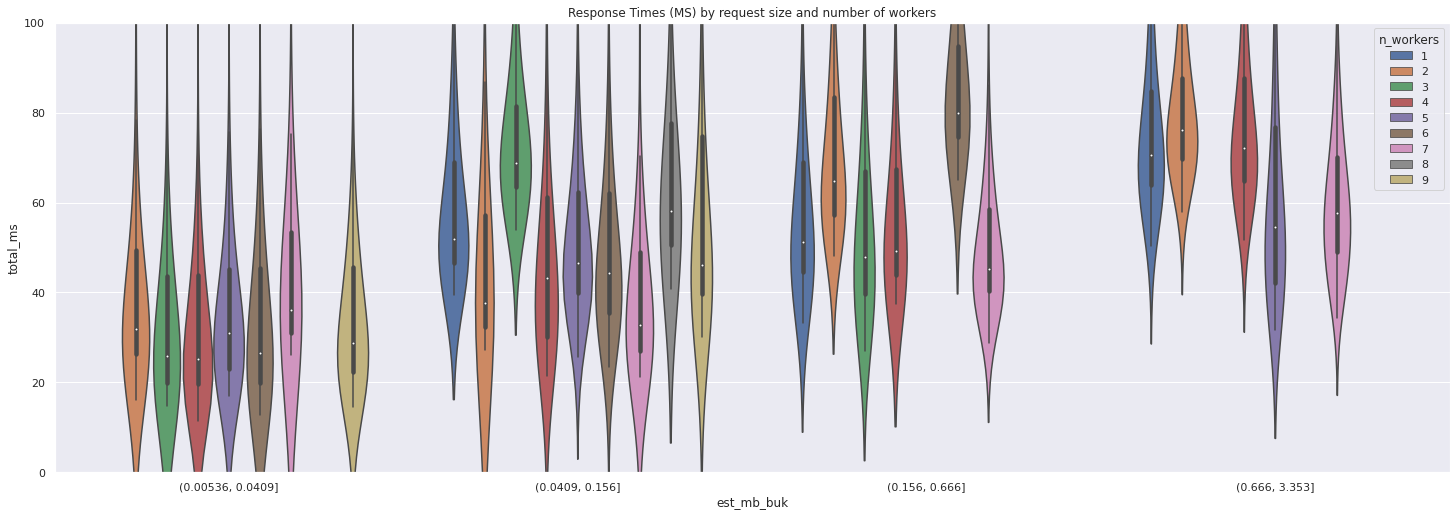

In [39]:
# categorical chart
#create quantiles for n_features and n
import matplotlib.pyplot as plt
import seaborn as sns


a4_dims = (25, 8.27)
fig, ax = plt.subplots(figsize=a4_dims)
#fig2, ax2 = plt.subplots(figsize=a4_dims)
sns.set(rc={'figure.figsize':(11.7,8.27)})
data['est_mb_buk'] = pd.qcut(data['est_mb'], 4)
#remove observations with less than 50 measurments
#data['point'] = str(data['n_workers']) + "_" + str(data['n_features']) + "_" + str(data['n_predictions'])
                                                                                  
violin_plot = sns.violinplot(x="est_mb_buk", y="total_ms", hue="n_workers",
               data=data, kind="violin", ax=ax)
violin_plot.set(ylim=(0, 100))
violin_plot.set(title='Response Times (MS) by request size and number of workers')


[(0.0, 100.0)]

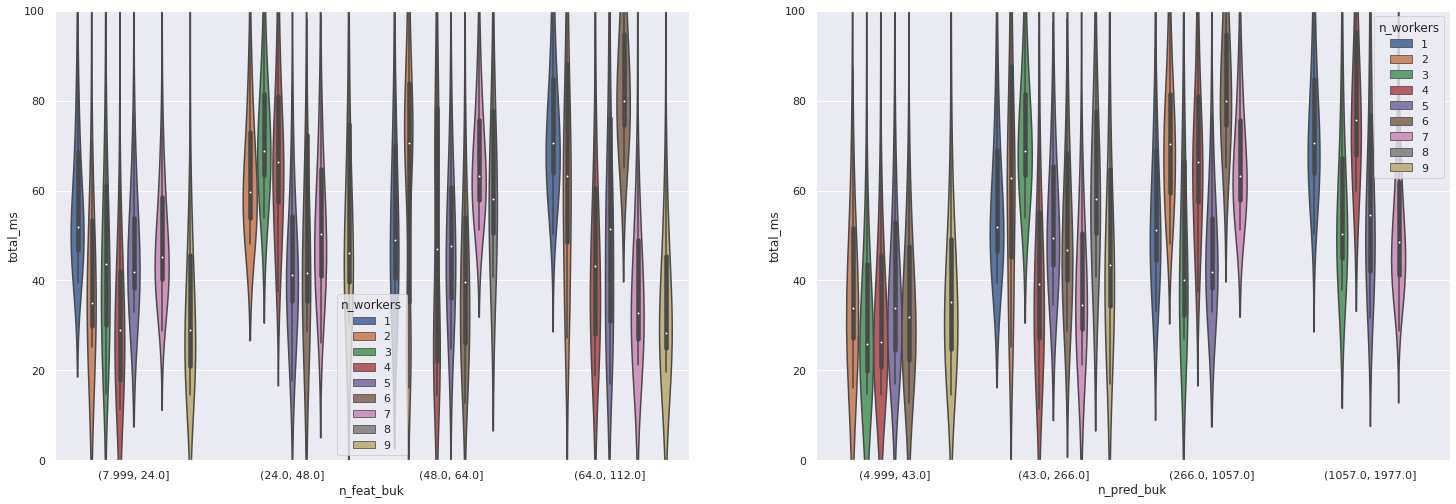

In [40]:
# categorical chart
#create quantiles for n_features and n
import matplotlib.pyplot as plt
import seaborn as sns


a4_dims = (25, 8.27)
fig, ax = plt.subplots(1, 2, figsize=a4_dims)
#fig2, ax2 = plt.subplots(figsize=a4_dims)
sns.set(rc={'figure.figsize':(11.7,8.27)})
data['n_feat_buk'] = pd.qcut(data['n_features'], 4)
data['n_pred_buk'] = pd.qcut(data['n_predictions'], 4)
#remove observations with less than 50 measurments
#data['point'] = str(data['n_workers']) + "_" + str(data['n_features']) + "_" + str(data['n_predictions'])
                                                                                  
violin_plot = sns.violinplot(x="n_feat_buk", y="total_ms", hue="n_workers",
               data=data, kind="violin", ax=ax[0])
violin_plot.set(ylim=(0, 100))

violin_plot2 = sns.violinplot(x="n_pred_buk", y="total_ms", hue="n_workers",
               data=data, kind="violin", ax=ax[1])
violin_plot2.set(ylim=(0, 100))


## OLS ANOVA
Simple analysis to find relationships that do/do not matter - depends on model specification
See model paramters/weights to understand very broadly how the variables relate to MS time

In [41]:
# ols model

model = ols("""total_ms ~ n_features + n_predictions + n_workers + est_mb
            """, data=data).fit()

table = sm.stats.anova_lm(model, typ=3)
table


,sum_sq,df,F,PR(>F)
Intercept,5.370437e+06,1.0,2333.894936,0.000000e+00
n_features,2.616380e+05,1.0,113.703146,1.752075e-26
n_predictions,4.596338e+04,1.0,19.974856,7.885184e-06
n_workers,1.362607e+05,1.0,59.216454,1.470691e-14
est_mb,6.230956e+04,1.0,27.078611,1.970691e-07
Residual,5.153228e+07,22395.0,NaN,NaN


In [42]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               total_ms   R-squared:                       0.034
Model:                            OLS   Adj. R-squared:                  0.034
Method:                 Least Squares   F-statistic:                     196.9
Date:                Mon, 25 Oct 2021   Prob (F-statistic):          2.91e-166
Time:                        14:39:26   Log-Likelihood:            -1.1848e+05
No. Observations:               22400   AIC:                         2.370e+05
Df Residuals:                   22395   BIC:                         2.370e+05
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept        57.4170      1.189     48.310      0.000      55.088      59.747
n_features        0.1857      0.017     10.663      0.000       0.152       0.220
n_predictions     0.0047      0.001      4.469      0.000       0.003       0.007
n_workers        -1.1531      0.150     -7.695      0.000      -1.447      -0.859
est_mb            4.5403      0.873      5.204      0.000       2.830       6.250
==============================================================================
Omnibus:                    10458.015   Durbin-Watson:                   1.265
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            56555.793
Skew:                           2.250   Prob(JB):                         0.00
Kurtosis:                       9.352   Cond. No.                     3.40e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.4e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

## Visualize the response surface by the variables

In [43]:
#create data aggregates for visualization

def p90(g):
    return np.percentile(g, 90)

data_avg = pd.pivot_table(data, 'total_ms', index=['n_workers','n_features', 'n_predictions'], aggfunc=np.average)
data_med = pd.pivot_table(data, 'total_ms', index=['n_workers','n_features', 'n_predictions'], aggfunc=np.median)
data_p90 = pd.pivot_table(data, 'total_ms', index=['n_workers','n_features', 'n_predictions'], aggfunc=p90)
data_avg = data_avg.reset_index()
data_med = data_med.reset_index()
data_p90 = data_p90.reset_index()

### By est_MB - best picture

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:16: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().
  app.launch_new_instance()


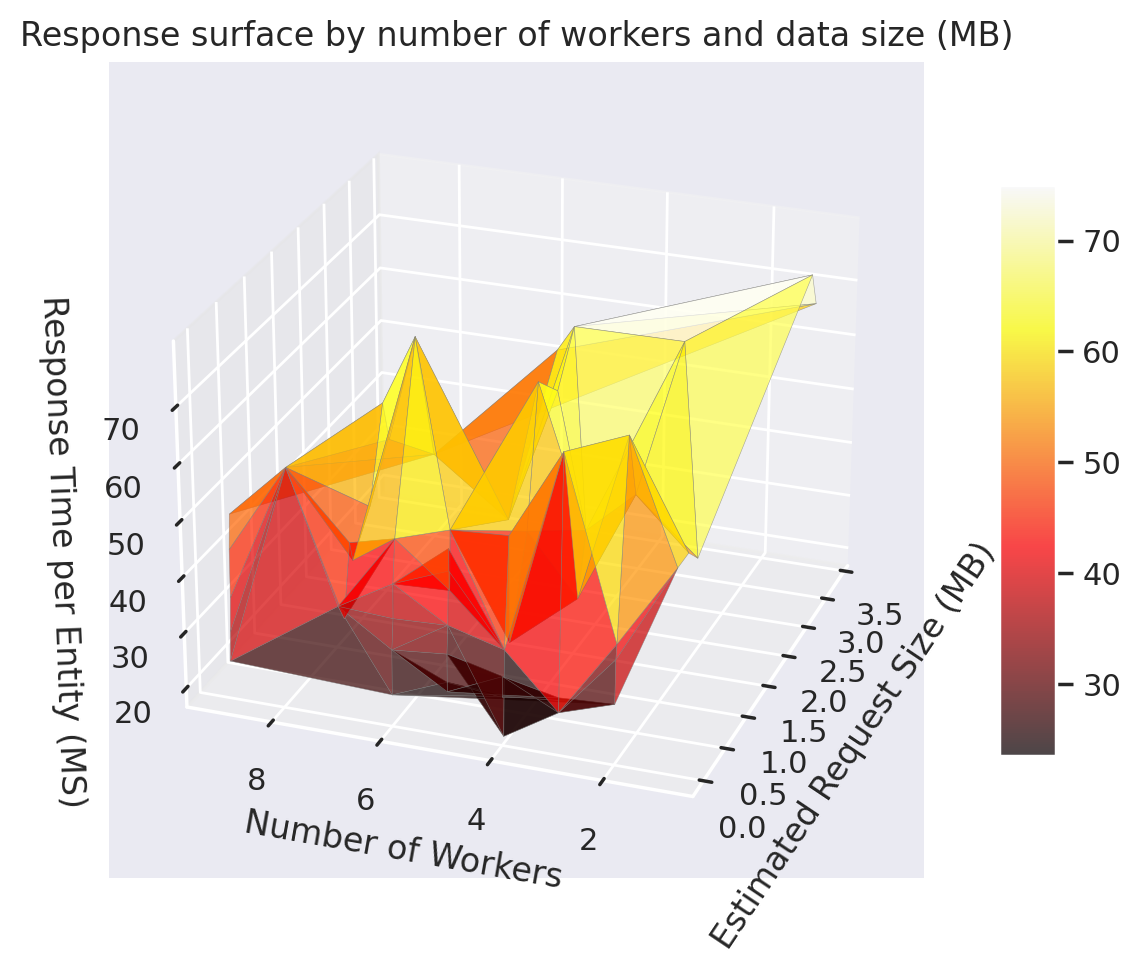

In [65]:
# libraries
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.colors import LightSource


light = (90, 120)
figsize=(16*.6,9*.6)
my_cmap = plt.get_cmap('hot')
 
# # Rotate it
fig = plt.figure(figsize=figsize, dpi=200)
ax = fig.gca(projection='3d')
data_med = pd.pivot_table(data, 'total_ms', index=['n_workers','est_mb'], aggfunc=np.median).reset_index()
trisurf = ax.plot_trisurf(data_med['est_mb'], data_med['n_workers'], data_med['total_ms']
                          , cmap=my_cmap, linewidth=0.2, alpha=0.7, antialiased = True,
                         edgecolor = 'grey', lightsource=light)
ax.view_init(25, 200)
ax.set_xlabel('Estimated Request Size (MB)')
ax.set_ylabel('Number of Workers')
ax.set_zlabel('Response Time per Entity (MS)')
fig.colorbar(trisurf, ax = ax, shrink = 0.7, aspect = 10 )
plt.title('Response surface by number of workers and data size (MB)')
plt.show()

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:16: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().
  app.launch_new_instance()


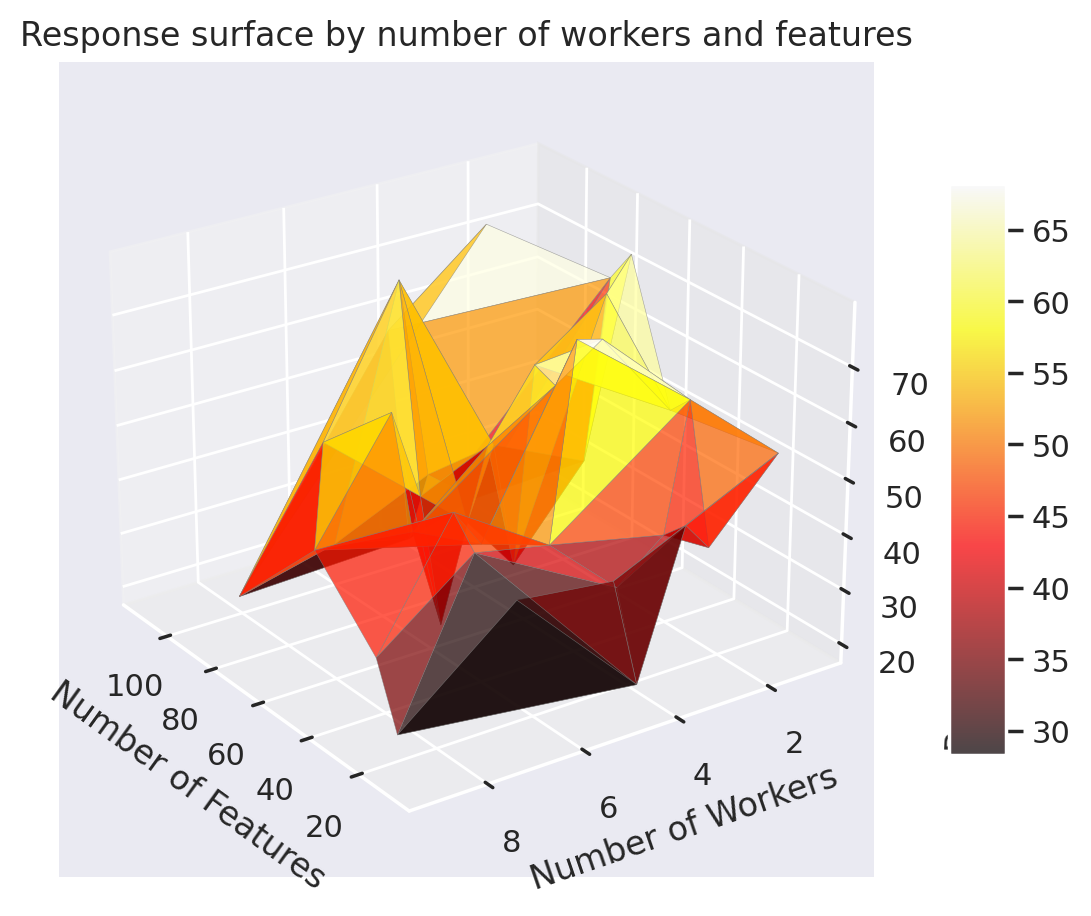

In [54]:
# libraries
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.colors import LightSource


light = (90, 20)
figsize=(16*.6,9*.6)
my_cmap = plt.get_cmap('hot')
 
# # Rotate it
fig = plt.figure(figsize=figsize, dpi=200)
ax = fig.gca(projection='3d')
data_med = pd.pivot_table(data, 'total_ms', index=['n_workers','n_features'], aggfunc=np.median).reset_index()
trisurf = ax.plot_trisurf(data_med['n_features'], data_med['n_workers'], data_med['total_ms']
                          , cmap=my_cmap, linewidth=0.2, alpha=0.7, antialiased = True,
                         edgecolor = 'grey', lightsource=light)
ax.view_init(25, 145)
ax.set_xlabel('Number of Features')
ax.set_ylabel('Number of Workers')
ax.set_zlabel('Response Time per Entity (MS)')
fig.colorbar(trisurf, ax = ax, shrink = 0.7, aspect = 10 )
plt.title('Response surface by number of workers and features')
plt.show()

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:15: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().
  from ipykernel import kernelapp as app


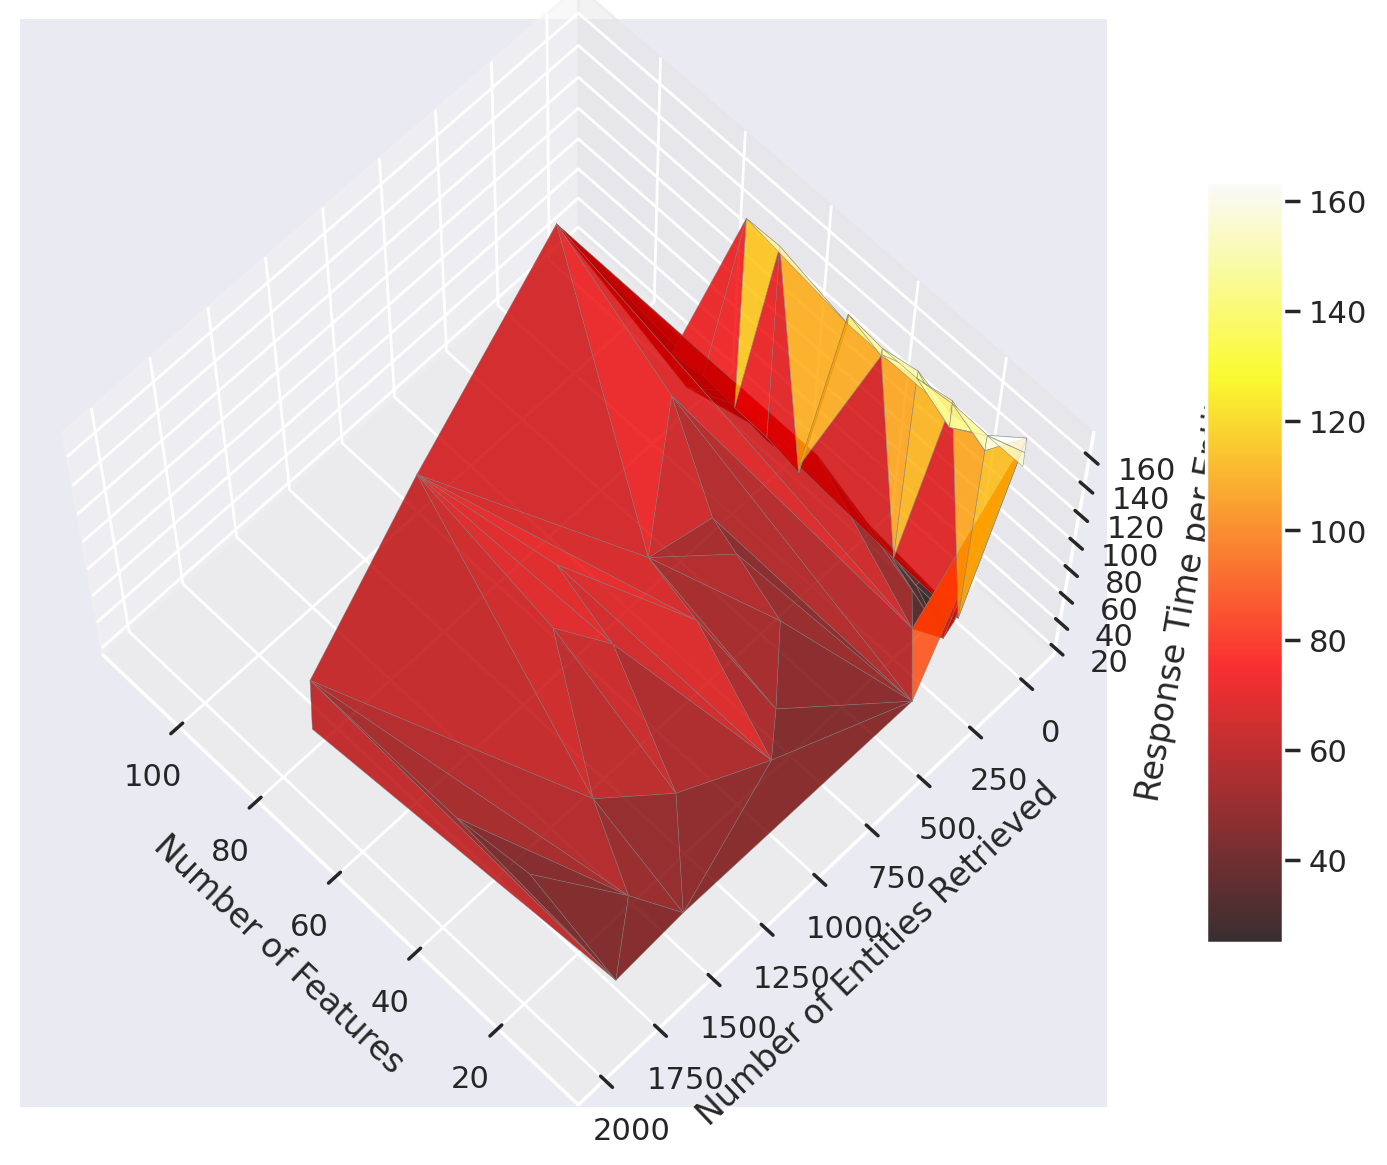

In [11]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.colors import LightSource


light = (90, 20)
figsize=(16*.8,9*.8)
my_cmap = plt.get_cmap('hot')
 
# Rotate it
fig = plt.figure(figsize=figsize, dpi=200)
ax = fig.gca(projection='3d')
data_med = pd.pivot_table(data, 'total_ms', index=['n_predictions','n_features'], aggfunc=np.median).reset_index()

trisurf = ax.plot_trisurf(data_med['n_features'], data_med['n_predictions'], data_med['total_ms']
                          , cmap=my_cmap, linewidth=0.2, alpha=0.8, antialiased = True,
                         edgecolor = 'grey', lightsource=light)
ax.view_init(65, 135)
ax.set_xlabel('Number of Features')
ax.set_ylabel('Number of Entities Retrieved')
ax.set_zlabel('Response Time per Entity (MS)')
fig.colorbar(trisurf, ax = ax, shrink = 0.7, aspect = 10 )

plt.show()

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:15: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().
  from ipykernel import kernelapp as app


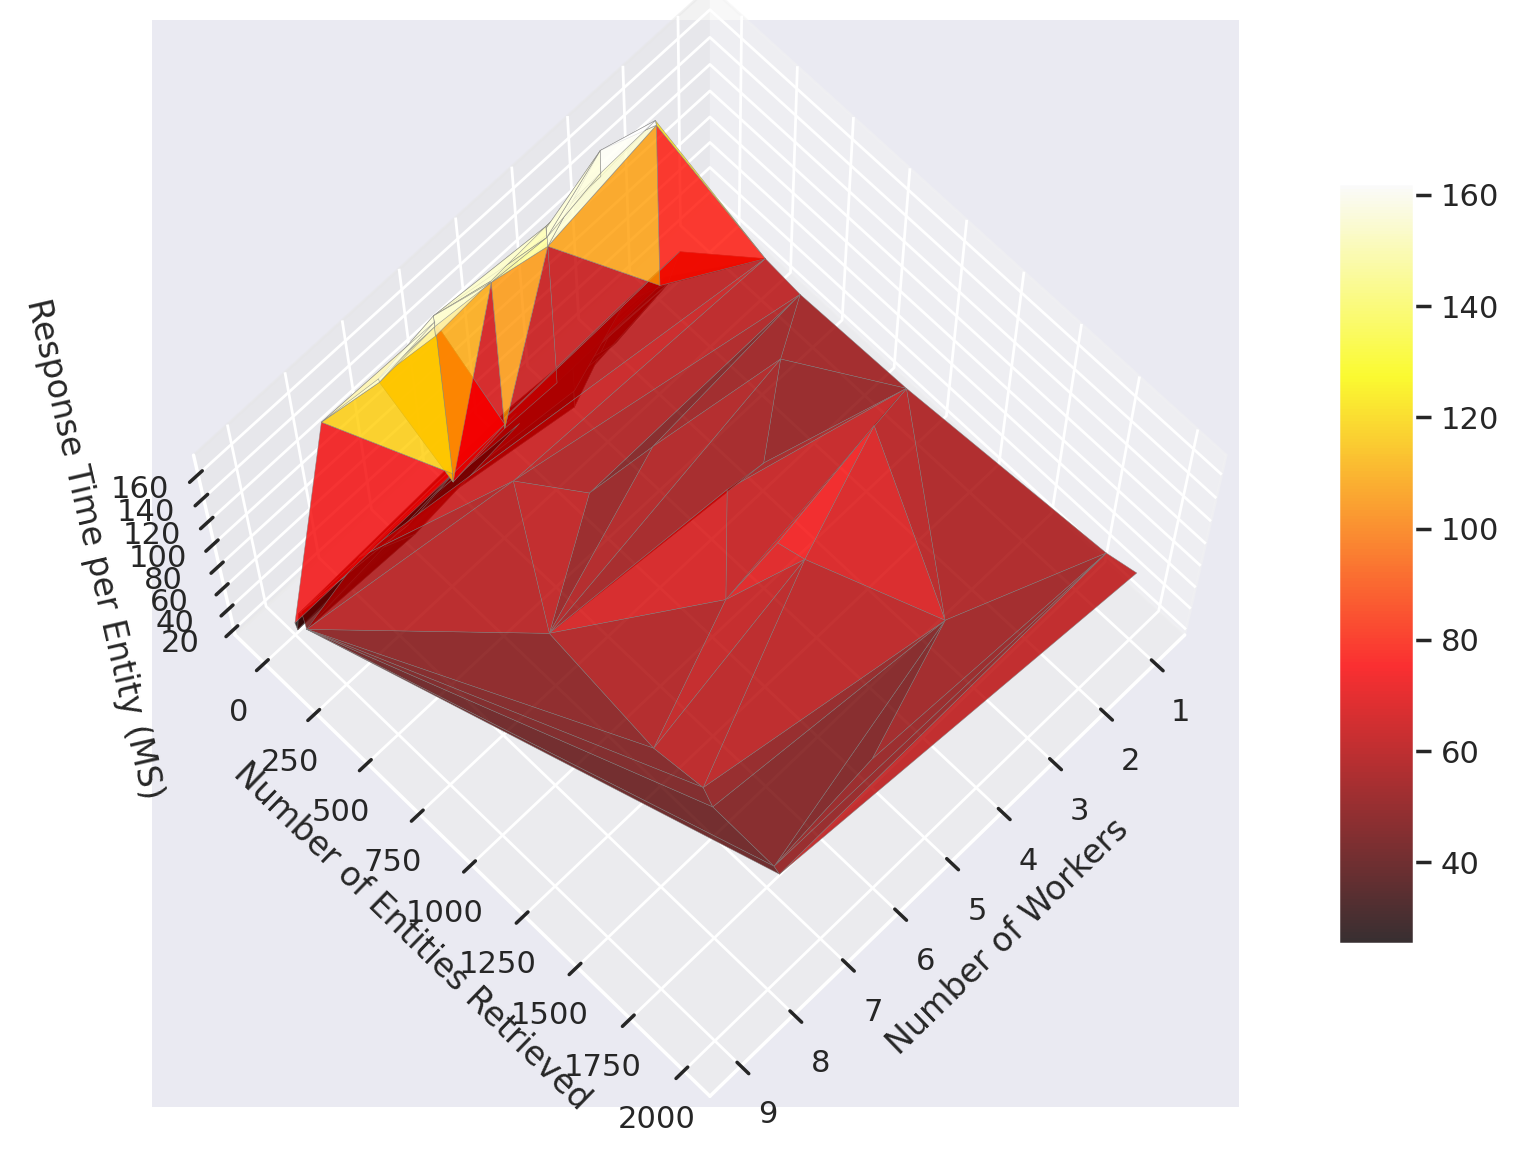

In [12]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.colors import LightSource


light = (90, 20)
figsize=(16*.8,9*.8)
my_cmap = plt.get_cmap('hot')
 
# Rotate it
fig = plt.figure(figsize=figsize, dpi=200)
ax = fig.gca(projection='3d')

data_med = pd.pivot_table(data, 'total_ms', index=['n_predictions','n_workers'], aggfunc=np.median).reset_index()
trisurf = ax.plot_trisurf(data_med['n_workers'], data_med['n_predictions'], data_med['total_ms']
                          , cmap=my_cmap, linewidth=0.2, alpha=0.8, antialiased = True,
                         edgecolor = 'grey', lightsource=light)
ax.view_init(70, 45)
ax.set_xlabel('Number of Workers')
ax.set_ylabel('Number of Entities Retrieved')
ax.set_zlabel('Response Time per Entity (MS)')
fig.colorbar(trisurf, ax = ax, shrink = 0.7, aspect = 10 )

plt.show()

## Pairplot

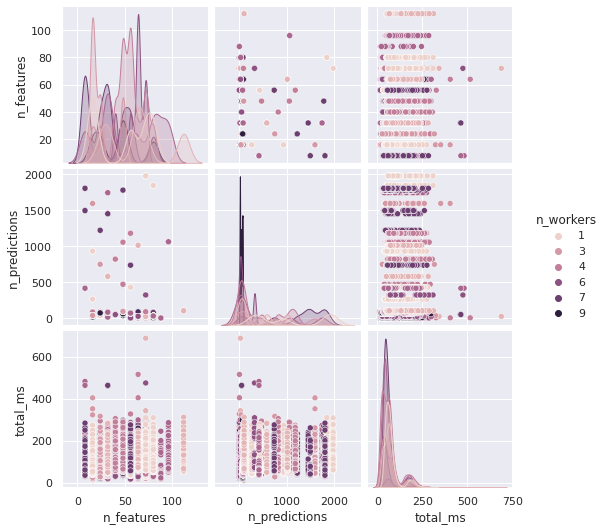

In [66]:
#Seaborn pair plot
df_3d = pd.DataFrame()
df_3d['n_features'] = data['n_features']
df_3d['n_workers'] = data['n_workers']
df_3d['n_predictions'] = data['n_predictions']
df_3d['total_ms'] = data['total_ms']

sns.pairplot(df_3d, hue='n_workers' )